In [1]:
import glob
import os
import omegaconf

import pandas as pd

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb40_random_epoch80_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/Sex_ukb40_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 5

In [3]:
participants = pd.read_csv(participants_file, index_col=0)
participants

,Sex,Age,BrainVolumeFreeSurfer_mm3,Ageattendedimaging,ImagingName,isBigBrain,isOld
participant_id,,,,,,,
sub-3411469,1,65.0,1136465.0,65.0,Cheadle,NaN,NaN
sub-2290292,0,69.0,1079118.0,69.0,Newcastle,NaN,NaN
sub-3842391,0,70.0,1124077.0,70.0,Cheadle,NaN,NaN
sub-2758537,1,49.0,1246758.0,49.0,Newcastle,NaN,0.0
sub-4334619,1,70.0,1410387.0,70.0,Cheadle,1.0,NaN
...,...,...,...,...,...,...,...
sub-2621329,1,56.0,1260788.0,56.0,Cheadle,NaN,NaN
sub-5057890,1,72.0,1328760.0,72.0,Cheadle,NaN,NaN
sub-2038574,1,70.0,1244624.0,70.0,Reading,NaN,NaN


In [4]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [5]:
model_paths = get_model_paths(path_champollion)

In [6]:
model_paths

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_left/11-42-04_96_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SFinter-SFsup_left/20-35-42_194_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/STi-STs-STpol_right/13-58-38_123_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_right/11-53-20_181_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_right/11-36-10_85_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/Lobule_parietal_sup_left/17-03-38_155_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SFint-SR_left/19-00-08_34_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SPoC_left/19-08-58_16_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained

In [7]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop(label, axis=1)
    Y = merged[label]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter, random_state=1)
    res = cross_val_score(model, X, Y, cv=cv, scoring='roc_auc')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [8]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-42-04_96_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_left/11-42-04_96_0
[0.72214817 0.71519624 0.73103487 0.71865664 0.74130385]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/20-35-42_194_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SFinter-SFsup_left/20-35-42_194_0
[0.69321419 0.68942552 0.69018572 0.67718682 0.69549177]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/13-58-38_123_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/STi-STs-STpol_right/13-58-38_123_0
[0.73144378 0.73487381 0.73514122 0.73908552 0.73366656]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/11-53-20_181_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_right/11-53-20_181_0
[0.82270917 0.81809222 0.82756069 0.81647677 0.81669496]
Treating S.C.-sylv._right: SC-sylv_right/11-36-10_85_0 :

In [9]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [10]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.725668,0.009429,11-42-04_96_0,SC-sylv_left/11-42-04_96_0,/neurospin/dico/data/deep_folding/current/mode...
1,S.F.inter.-S.F.sup._left,0.689101,0.006340,20-35-42_194_0,SFinter-SFsup_left/20-35-42_194_0,/neurospin/dico/data/deep_folding/current/mode...
2,S.T.i.-S.T.s.-S.T.pol._right,0.734842,0.002491,13-58-38_123_0,STi-STs-STpol_right/13-58-38_123_0,/neurospin/dico/data/deep_folding/current/mode...
3,F.Coll.-S.Rh._right,0.820307,0.004266,11-53-20_181_0,FColl-SRh_right/11-53-20_181_0,/neurospin/dico/data/deep_folding/current/mode...
4,S.C.-sylv._right,0.720269,0.005750,11-36-10_85_0,SC-sylv_right/11-36-10_85_0,/neurospin/dico/data/deep_folding/current/mode...
5,Lobule_parietal_sup._left,0.744170,0.005190,17-03-38_155_0,Lobule_parietal_sup_left/17-03-38_155_0,/neurospin/dico/data/deep_folding/current/mode...
6,S.F.int.-S.R._left,0.718174,0.007456,19-00-08_34_0,SFint-SR_left/19-00-08_34_0,/neurospin/dico/data/deep_folding/current/mode...
7,S.Po.C._left,0.707766,0.004139,19-08-58_16_0,SPoC_left/19-08-58_16_0,/neurospin/dico/data/deep_folding/current/mode...
8,S.F.inf.-BROCA-S.Pe.C.inf._right,0.676885,0.006398,13-18-55_195_0,SFinf-BROCA-SPeCinf_right/13-18-55_195_0,/neurospin/dico/data/deep_folding/current/mode...
9,S.s.P.-S.Pa.int._left,0.731671,0.007843,16-56-37_137_0,SsP-SPaint_left/16-56-37_137_0,/neurospin/dico/data/deep_folding/current/mode...


In [11]:
df['side'] = df['region'].str.split('_').str[-1]

In [12]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 0.85))
    ax.set_title(title)


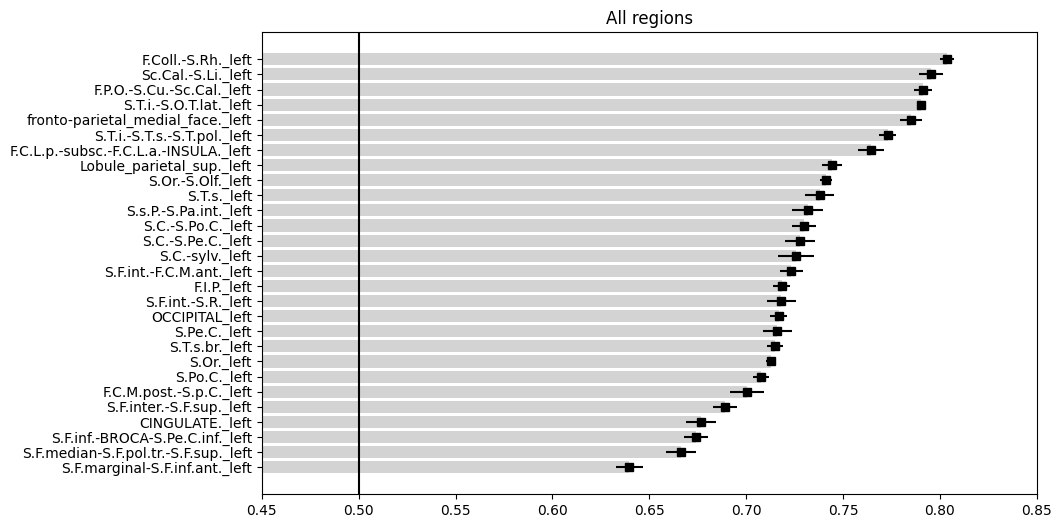

In [13]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

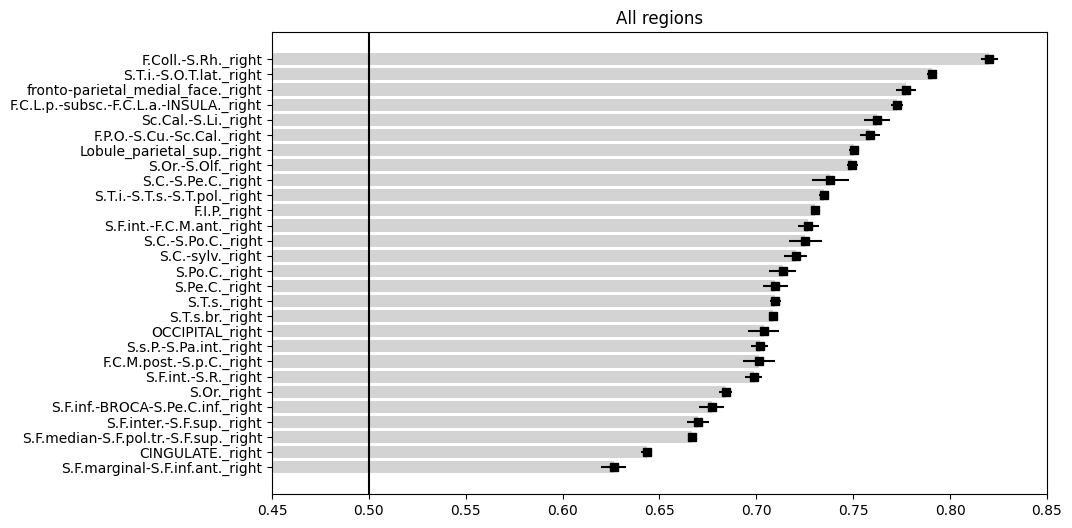

In [14]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [16]:
# df.to_csv(output_filename)